Derivative Of Activation Functions

<p style="font-size: 17px">
The following cell contains an implementation of some activation functions.p>

In [1]:
import torch

def sigmoid(x):
    return 1 / (1 + torch.exp(-x))

def tanh(x):
    return torch.div(torch.exp(x) - torch.exp(-x), torch.exp(x) + torch.exp(-x))


def softmax(x):
    exp_x = torch.exp(x.T - torch.max(x, dim=-1).values).T  # Subtracting max(x) for numerical stability
    return exp_x / exp_x.sum(dim=-1, keepdim=True)

In [2]:
def d_sigmoid(x):
    sigmoid_x = sigmoid(x)
    return sigmoid_x * (1 - sigmoid_x)



def d_tanh(x):
    return 1 - torch.pow(tanh(x), 2)



def d_softmax(x):
    s = softmax(x)
    s_diag = torch.diagflat(s)
    return s_diag - torch.einsum('bi,bj->bij', s, s)

## II. Train a Fully Connected network on MNIST

<p style="font-size: 19px">Creating a classifier for the MNIST dataset using torch tensor manipulation:

constraints:
<ul>
<li>  NOT allowed to use:
  <ul>
  <li> Auto-differentiation - backward()</li>
  <li> Built-in loss functions</li>
  <li> Built-in activations</li>
  <li> Built-in optimization</li>
  <li> Built-in layers (torch.nn)</li>
  </ul>
  </li>
</ul>
</h4>

<p style="font-size: 17px">
The required classifier class is defined.
<ul style="font-size: 17px">
<li> my implementation of the backward pass of the model.
<li> Train the model and plot the model's accuracy and loss (both on train and test sets) as a function of the epochs.
</ul>
</p>

In [260]:
import torch
import torchvision
from torch.utils.data import DataLoader

import os
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

# Constants
SEED = 42
EPOCHS = 16
BATCH_SIZE = 32
NUM_OF_CLASSES = 10

# Setting seed
def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ["PYTHONHASHSEED"] = str(seed)


# Transformation for the data
transform = torchvision.transforms.Compose(
    [torchvision.transforms.ToTensor(),
     torch.flatten])


# Cross-Entropy loss implementation
def one_hot(y, num_of_classes=10):
    hot = torch.zeros((y.size()[0], num_of_classes))
    hot[torch.arange(y.size()[0]), y] = 1
    return hot

def cross_entropy(y, y_hat):
    return -torch.sum(one_hot(y) * torch.log(y_hat)) / y.size()[0]


In [261]:
# Create dataloaders
train_dataset = torchvision.datasets.MNIST(root='./data', train=True,
                                            download=True, transform=transform)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE)


test_dataset = torchvision.datasets.MNIST(root='./data', train=False,
                                           download=True, transform=transform)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE)


In [262]:
class FullyConnectedNetwork:
    def __init__(self, input_size, output_size, hidden_size1, activiation_func, lr):
        # parameters
        self.input_size = input_size
        self.output_size = output_size
        self.hidden_size1 = hidden_size1

        # activation function
        self.activation_func = activiation_func

        # weights
        self.W1 = torch.randn(self.input_size, self.hidden_size1)
        self.b1 = torch.zeros(self.hidden_size1)

        self.W2 = torch.randn(self.hidden_size1, self.output_size)
        self.b2 = torch.zeros(self.output_size)

        self.lr = lr

    def forward(self, x):
        #apply the first layer transformation
        z1 = torch.matmul(x, self.W1) + self.b1
        #apply activation function 
        h1 = self.activation_func(z1)
        #apply the second layer transformation
        z2 = torch.matmul(h1, self.W2) + self.b2
        #apply activation function 
        y_hat = softmax(z2)
        return y_hat

    def backward(self, x, y, y_hat):
        y_one_hot = one_hot(y, self.output_size)
        h = self.activation_func(torch.mm(x, self.W1) + self.b1)
        dl_dy_hat = (y_hat - y_one_hot)
        dl_dh = torch.matmul(dl_dy_hat, torch.t(self.W2))
        dl_dz1 = dl_dh * h * (1 - h)


        self.W1 -= self.lr*torch.matmul(torch.t(x), dl_dz1)
        self.b1 -= self.lr*dl_dz1.sum(0)
        self.W2 -= self.lr*torch.matmul(torch.t(h), dl_dy_hat)
        self.b2 -= self.lr*dl_dy_hat.sum(0)
        
set_seed(SEED)
model = FullyConnectedNetwork(784, 10, 128, sigmoid, 0.01)

Epoch 1: Train Loss: 0.6991, Train Accuracy: 0.8227, Test Loss: 0.3846, Test Accuracy: 0.8854
Epoch 2: Train Loss: 0.3120, Train Accuracy: 0.9091, Test Loss: 0.3002, Test Accuracy: 0.9082
Epoch 3: Train Loss: 0.2455, Train Accuracy: 0.9280, Test Loss: 0.2647, Test Accuracy: 0.9201
Epoch 4: Train Loss: 0.2091, Train Accuracy: 0.9391, Test Loss: 0.2428, Test Accuracy: 0.9256
Epoch 5: Train Loss: 0.1843, Train Accuracy: 0.9459, Test Loss: 0.2268, Test Accuracy: 0.9307
Epoch 6: Train Loss: 0.1656, Train Accuracy: 0.9522, Test Loss: 0.2146, Test Accuracy: 0.9347
Epoch 7: Train Loss: 0.1506, Train Accuracy: 0.9567, Test Loss: 0.2052, Test Accuracy: 0.9378
Epoch 8: Train Loss: 0.1381, Train Accuracy: 0.9609, Test Loss: 0.1981, Test Accuracy: 0.9404
Epoch 9: Train Loss: 0.1273, Train Accuracy: 0.9638, Test Loss: 0.1926, Test Accuracy: 0.9421
Epoch 10: Train Loss: 0.1180, Train Accuracy: 0.9667, Test Loss: 0.1883, Test Accuracy: 0.9421
Epoch 11: Train Loss: 0.1098, Train Accuracy: 0.9691, Test 

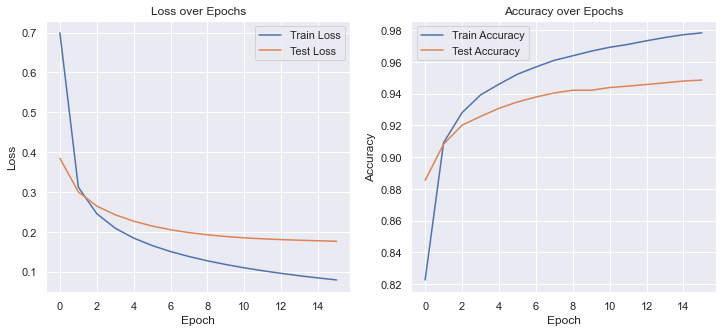

In [263]:
import matplotlib.pyplot as plt

# Initialize lists to store metrics
train_losses, test_losses = [], []
train_accuracies, test_accuracies = [], []

# Training Loop
for epoch in range(EPOCHS):
    train_loss, train_correct, train_total = 0, 0, 0
    
    for i, (x,y) in enumerate(train_dataloader):
        x = x.view(x.shape[0], -1)  # Flatten the images
        y_hat = model.forward(x)

        loss = cross_entropy(y, y_hat)


        model.backward(x, y, y_hat)  # Backward pass to update weights
        
        train_loss += loss.item()
        _, predicted = torch.max(y_hat, 1)
        train_total += y.size(0)
        train_correct += (predicted == y).sum().item()
    
    train_losses.append(train_loss / len(train_dataloader))
    train_accuracies.append(train_correct / train_total)

    # Evaluation phase
    test_loss, test_correct, test_total = 0, 0, 0
    # with torch.no_grad():  # No gradients needed for evaluation
    for x, y in test_dataloader:
        x = x.view(x.shape[0], -1)
        y_hat = model.forward(x)
        loss = cross_entropy(y, y_hat)
        
        test_loss += loss.item()
        _, predicted = torch.max(y_hat, 1)
        test_total += y.size(0)
        test_correct += (predicted == y).sum().item()

    test_losses.append(test_loss / len(test_dataloader))
    test_accuracies.append(test_correct / test_total)

    print(f'Epoch {epoch+1}: Train Loss: {train_losses[-1]:.4f}, Train Accuracy: {train_accuracies[-1]:.4f}, Test Loss: {test_losses[-1]:.4f}, Test Accuracy: {test_accuracies[-1]:.4f}')

# Plotting
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [265]:
students_ids = "212104855_206528382"
torch.save({"W1": model.W1, "W2": model.W2, "b1": model.b1, "b2": model.b2}, f"HW1_{students_ids}.pkl")

<p style="font-size: 17px"> b) Train the model with various learning rates (at least 3).
<ul style="font-size: 17px">
<li> Plot the model's accuracy and loss (both on train and test sets) as a function of the epochs.
<li>Discuss the differences in training with different learning rates. Support your answer with plots.

learning rate: 0.01


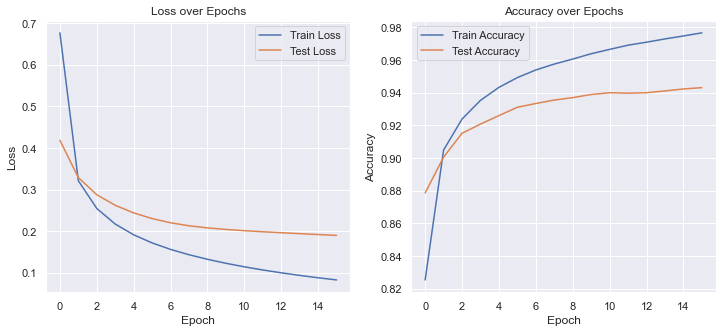

learning rate: 0.001


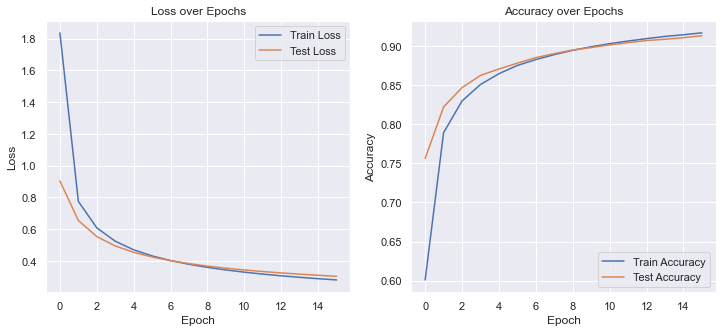

learning rate: 0.0001


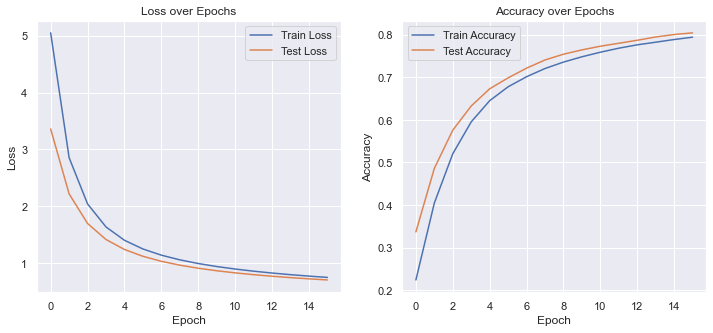

In [232]:
learning_rates = [0.01, 0.001, 0.0001]

for learning_rate in learning_rates:
    model = FullyConnectedNetwork(784, 10, 128, sigmoid, learning_rate)
    
    # Initialize lists to store metrics
    train_losses, test_losses = [], []
    train_accuracies, test_accuracies = [], []

    # Training Loop
    for epoch in range(EPOCHS):
        train_loss, train_correct, train_total = 0, 0, 0

        for i, (x,y) in enumerate(train_dataloader):
            x = x.view(x.shape[0], -1)  # Flatten the images
            y_hat = model.forward(x)

            loss = cross_entropy(y, y_hat)


            model.backward(x, y, y_hat)  # Backward pass to update weights

            train_loss += loss.item()
            _, predicted = torch.max(y_hat, 1)
            train_total += y.size(0)
            train_correct += (predicted == y).sum().item()

        train_losses.append(train_loss / len(train_dataloader))
        train_accuracies.append(train_correct / train_total)

        # Evaluation phase
        test_loss, test_correct, test_total = 0, 0, 0
        # with torch.no_grad():  # No gradients needed for evaluation
        for x, y in test_dataloader:
            x = x.view(x.shape[0], -1)
            y_hat = model.forward(x)
            loss = cross_entropy(y, y_hat)

            test_loss += loss.item()
            _, predicted = torch.max(y_hat, 1)
            test_total += y.size(0)
            test_correct += (predicted == y).sum().item()

        test_losses.append(test_loss / len(test_dataloader))
        test_accuracies.append(test_correct / test_total)

#         print(f'Epoch {epoch+1}: Train Loss: {train_losses[-1]:.4f}, Train Accuracy: {train_accuracies[-1]:.4f}, Test Loss: {test_losses[-1]:.4f}, Test Accuracy: {test_accuracies[-1]:.4f}')

    # Plotting
    print(f'learning rate: {learning_rate}')
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(test_losses, label='Test Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Train Accuracy')
    plt.plot(test_accuracies, label='Test Accuracy')
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()


**Discuss the differences in training with different learning rates:**

When training a neural network, the choice of learning rate can significantly impact the convergence speed and final performance of the model. 

**Learning Rate = 0.01:**

- With a relatively high learning rate, the model updates its parameters by large steps during each iteration.
- Initially, this may lead to rapid progress in reducing the training loss. However, it can also result in overshooting the optimal parameters and oscillating around the minimum.
- If the learning rate is too high, it may lead to instability and divergence of the training process, causing the loss to fluctuate wildly and preventing convergence.

**Learning Rate = 0.001:**

- A moderate learning rate typically allows for smoother convergence compared to a high learning rate.
- With a smaller learning rate, the model's parameter updates are more conservative, preventing overshooting and oscillations.
- While training may take longer compared to a higher learning rate, it often results in more stable convergence and better generalization performance.

**Learning Rate = 0.0001:**

- A very low learning rate requires a large number of iterations to make meaningful progress in reducing the loss.
- While training with a very low learning rate can be computationally expensive and time-consuming, it may lead to better convergence and improved performance, especially when dealing with complex datasets.


By comparing these plots, we can visualize how different learning rates affect the training process and understand their impact on convergence speed and final model performance.






## I. Implement and Train a CNN 

<p style="font-size: 17px"> You are a data scientist at a supermarket. Your manager asked you to write a new image classifiaction algorithem for the self checkout cashiers. The images are of products from your grocery store (dataset files are attched in the Moodle).
<br>
Your code and meet the following constraints:
<ul style="font-size: 17px">
<li> Your classifier must be CNN based</li>
<li> You are not allowed to use any pre-trained model</li>
</ul>
<br>
<p style="font-size: 17px">
In order to satisfy your boss you have to reach 65% accuracy on the test set. You will get a bonus for your salary (and 10 points to your grade) if your model's number of paramters is less than 100K. You can reutilize code from the tutorials.

<ul style="font-size: 17px">
<li>Train the model and plot the model's accuracy and loss (both on train and validation sets) as a function of the epochs. </li>
<li>Report the test set accurecy.</li>
<li>Discus the progress you made and describe your final model.</li>

In [205]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.nn.functional as F
import os
from PIL import Image
import pandas as pd
from torch import nn
from torch.nn import Module
from torch.nn import Conv2d, ConvTranspose2d
from torch.nn import Linear
from torch.nn import MaxPool2d
from torch.nn import ReLU, ELU
from torch.nn import BatchNorm2d
from torch.nn import Sequential
from torch.nn import LogSoftmax
from torch.nn import NLLLoss
from torch.nn import AvgPool2d

In [206]:
num_epochs = 100
batch_size = 7
learning_rate = 0.001


In [207]:
class CustomDataset(Dataset):
    def __init__(self, txt_file, img_dir, transform=None):
        """
        Args:
            txt_file (string): Path to the txt file with annotations.
            img_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.img_labels = pd.read_csv(txt_file, names=['image', 'label'], sep=', ')
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = Image.open(img_path)
        label = int(self.img_labels.iloc[idx, 1])
        
        image = self.transform(image)
        return image, label

In [208]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(350),
        transforms.RandomResizedCrop(224),
        transforms.RandomRotation(5), 
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.1307, 0.1307, 0.1307], [0.3081, 0.3081, 0.3081])
    ]),
    'test' : transforms.Compose([
        transforms.Resize(350),
        transforms.RandomResizedCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.1307, 0.1307, 0.1307], [0.3081, 0.3081, 0.3081])
    ]),
    
    'val': transforms.Compose([
        transforms.Resize(350),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.1307, 0.1307, 0.1307], [0.3081, 0.3081, 0.3081])
    ]),
}

In [209]:
# Create the datasets
train_dataset = CustomDataset(txt_file='/Users/lanahaj/Desktop/GroceryStoreDataset/train.txt', img_dir='/Users/lanahaj/Desktop/GroceryStoreDataset', transform=data_transforms['train'])
test_dataset = CustomDataset(txt_file='/Users/lanahaj/Desktop/GroceryStoreDataset/test.txt', img_dir='/Users/lanahaj/Desktop/GroceryStoreDataset', transform=data_transforms['test'])
val_dataset = CustomDataset(txt_file='/Users/lanahaj/Desktop/GroceryStoreDataset/val.txt', img_dir='/Users/lanahaj/Desktop/GroceryStoreDataset', transform=data_transforms['val'])

# Create the dataloaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)


<ipython-input-207-97d35d76843f>:9: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  self.img_labels = pd.read_csv(txt_file, names=['image', 'label'], sep=', ')


In [210]:
#CNN model
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.layer1 = nn.Sequential(Conv2d(3, 16, kernel_size=3, stride=2, padding=3),
                                    BatchNorm2d(16),ELU(inplace=True),
                                    MaxPool2d(kernel_size=3, stride=3))
       
        self.layer2 = nn.Sequential(Conv2d(16, 64, kernel_size=3, stride=2, padding=3),
                                    BatchNorm2d(64), ELU(inplace=True), 
                                    MaxPool2d(kernel_size=3, stride=3))

        
        self.layer3 = nn.Sequential(ConvTranspose2d(64, 64, kernel_size=3, stride=2, padding=2),
                                    BatchNorm2d(64), ELU(inplace=True),
                                    MaxPool2d(kernel_size=2, stride=2))
        
       
        self.layer4 = nn.Sequential(ConvTranspose2d(64, 32, kernel_size=3, stride=1, padding=2),
                                    BatchNorm2d(32), ELU(inplace=True))
        
        self.linear_layer = Linear(288, 43) # 43 for num of classes
        self.dropout = nn.Dropout(p=0.5)
        self.logsoftmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = out.view(out.size(0), -1)
        out = self.dropout(out)
        out = self.linear_layer(out)
        return self.logsoftmax(out)

In [211]:
cnn = CNN()

# Loss and Optimizer
criterion = nn.NLLLoss()
optimizer = torch.optim.Adam(cnn.parameters(), lr=learning_rate)

print('number of parameters: ', sum(param.numel() for param in cnn.parameters()))

number of parameters:  77899


In [212]:
def model_eval(data_loader):
    cnn.eval()
    correct = 0
    total = 0

    for images, labels in data_loader:
        if torch.cuda.is_available():
            images = images.cuda()
            labels = labels.cuda()

        outputs = cnn(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum()
        loss = criterion(outputs, labels)
   

    return round(100.0 * ((correct / total).item())), loss.data

In [213]:
train_loss = []
train_accuracy = []
val_loss = []
val_accuracy = []
for epoch in range(num_epochs):
    cnn.train()
    curr_loss = 0
    total = 0
    correct = 0
    for i, (images, labels) in enumerate(train_loader):
        # Forward + Backward + Optimize
        outputs = cnn(images)
        total += len(labels)
        correct += torch.sum(torch.max(outputs,1)[1]==labels).item()*1.0
        loss = criterion(outputs, labels)
        curr_loss += loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    acc_val, loss_val = model_eval(val_loader)
    train_loss.append(curr_loss.item()/(len(train_loader)))
    train_accuracy.append(round(100.0* (correct/total)))
    val_loss.append(loss_val)
    val_accuracy.append(acc_val)
    
    if (epoch + 1) % 10 == 0:
        print("epoch number", epoch+1, ':')
        print(f'Train Accuracy: {train_accuracy[-1]}%')   
        print(f'Validation Accuracy: {val_accuracy[-1]}%')
        print(f'Test Accuracy: { model_eval(test_loader)[0]}%')

epoch number 10 :
Train Accuracy: 47%
Validation Accuracy: 47%
Test Accuracy: 49%
epoch number 20 :
Train Accuracy: 58%
Validation Accuracy: 48%
Test Accuracy: 55%
epoch number 30 :
Train Accuracy: 65%
Validation Accuracy: 51%
Test Accuracy: 54%
epoch number 40 :
Train Accuracy: 68%
Validation Accuracy: 56%
Test Accuracy: 61%
epoch number 50 :
Train Accuracy: 71%
Validation Accuracy: 53%
Test Accuracy: 62%
epoch number 60 :
Train Accuracy: 75%
Validation Accuracy: 60%
Test Accuracy: 63%
epoch number 70 :
Train Accuracy: 75%
Validation Accuracy: 53%
Test Accuracy: 60%
epoch number 80 :
Train Accuracy: 78%
Validation Accuracy: 63%
Test Accuracy: 64%
epoch number 90 :
Train Accuracy: 79%
Validation Accuracy: 63%
Test Accuracy: 65%
epoch number 100 :
Train Accuracy: 79%
Validation Accuracy: 62%
Test Accuracy: 66%


In [224]:
import numpy as np
def plot_measure(train_loss, test_loss, measure):
    plt.plot(range(len(train_loss)), train_loss, label=f'Train {measure}')
    plt.plot(range(len(test_loss)), test_loss, label=f'Validation {measure}')
    plt.xlabel('Epochs')
    plt.ylabel(measure)
    plt.legend()
    plt.show()


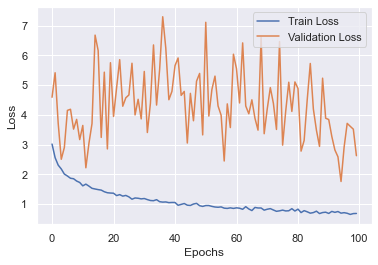

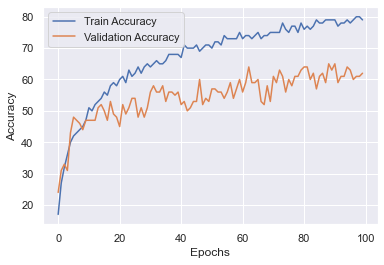

In [225]:
trainLoss = np.array(train_loss)
valLoss = np.array(val_loss)
trainAccuracy = np.array(train_accuracy)
valAccuracy = np.array(val_accuracy)
plot_measure(trainLoss, valLoss, "Loss")
plot_measure(trainAccuracy, valAccuracy, "Accuracy")

In [223]:
print(f'The Test set Accuracy: { model_eval(test_loader)[0]} %')

The Test set Accuracy: 65 %


# About the model

**Network Architecture:**
Through experimentation with different layer configurations, kernel sizes, and activation functions, we arrived at a model architecture that we believe is well-suited for the classification task at hand. The chosen architecture includes: 2 convolutional layers and 2 transposed convolutional layers and 1 linear layer, along with batch normalization(helps stabilize and accelerate the training process), ELU activation function enabling it to learn complex relationships within the data (we applied ELU activation function after we tried to use ReLU and Tanh but get the best results with ELU), MaxPool2d is applied to the first 3 layers (to reduce the spatial dimensions of feature maps) and also dropout with probability 0.5 is applied before the output layer to prevent overfitting.
The number of parameters of our model is 77899, which is less than 100K.

**Preprocessing the Data:**
Our preprocessing pipeline included resizing, cropping, and normalization of images, as well as the application of data augmentation techniques such as random rotation and horizontal flipping. These preprocessing steps were instrumental in augmenting the dataset and improving the model's ability to generalize to unseen data.

**Hyperparameters, Loss Function, and Optimizer:**
After many trials of different hyperparameters we got the required results with : num_epochs = 100, batch_size = 7 and learning_rate = 0.001.
We also decided to use NLLLoss loss function after we tried Cross Entropy and see that NLLLoss is better in our case, and also we read that NLLLoss is commonly used for multi-class classification tasks which in our task we have 42 class so according to the results NLLoss is more suitable for us.
for optimizer we used Adam optimizer with a learning rate of 0.001.


**Conclusion:**
We got Test accuracy 66% in epoch 100 with 77,899 parameters less than 100K as required.


## II. Analyzing a Pre-trained CNN (Filters) (10pt)

In this part, you are going to analyze a (large) pre-trained model. Pre-trained models are quite popular these days, as big companies can train really large models on large datasets (something that personal users can't do as they lack the sufficient hardware). These pre-trained models can be used to fine-tune on other/small datasets or used as components in other tasks (like using a pre-trained classifier for object detection).

All pre-trained models expect input images normalized in the same way, i.e. mini-batches of 3-channel RGB images of shape (3 x H x W), where H and W are expected to be at least 224. The images have to be loaded in to a range of [0, 1] and then normalized using mean = [0.485, 0.456, 0.406] and std = [0.229, 0.224, 0.225].

You can use the following transform to normalize:

<code>normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])</code>
<a href="https://pytorch.org/vision/stable/models.html">Read more here</a>


1. Load a pre-trained VGG16 with PyTorch using torchvision.models.vgg16(pretrained=True, progress=True, **kwargs) (<a href="https://pytorch.org/vision/stable/models.html#classification">read more here</a>). Don't forget to use the model in evaluation mode (<code>model.eval()</code>).

2. Load the images in the 'birds' folder and display them.

3. Pre-process the images to fit VGG16's architecture. What steps did you take?

4. Feed the images (forward pass) to the model. What are the outputs?

5. Choose an image of a dog in the 'dogs' folder, display it and feed it to network. What are the outputs?

6. For the first 3 filters in the first layer of VGG16, plot the filters, and then plot their response (their output) for the image from question 5. Explain your observations.

# Step 1: Loading a Pre-trained VGG16 Model

In [269]:
import torch
from torchvision import models, transforms
from PIL import Image
import matplotlib.pyplot as plt

# Load the pretrained model
model = models.vgg16(pretrained=True).eval()

# Step 2: Image Loading and Displaying

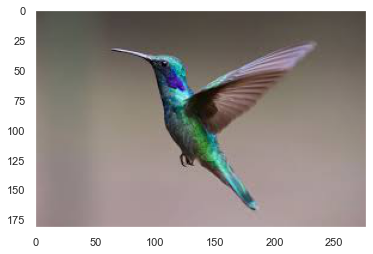

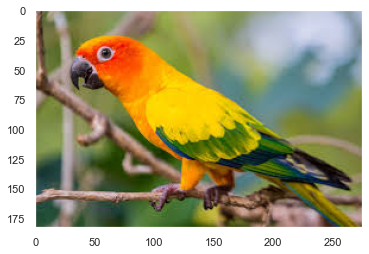

In [270]:
from pathlib import Path
from PIL import Image
plt.grid(False)

# Path to your 'birds' folder
birds_folder = Path("/Users/lanahaj/Desktop/HW1_data_updated/birds")

# Load and display images
for img_path in birds_folder.glob('*.jpg'):
    img = Image.open(img_path)
    plt.grid(False)

    plt.imshow(img)
    plt.show()

# Step 3:  Preprocess the images:
**The transformation code is exactly what we need to pre-process images for VGG16:**

- Resize images to 224x224.
- Convert them to a tensor.
- Normalize using the specified mean and std.

In [271]:
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


# Step 4:

In [277]:
birds = []
for img_path in birds_folder.glob('*.jpg'):
    img = Image.open(img_path)
    # Pre-process the image and create a mini batch that the model can handle
    input_tensor = preprocess(img)
    input_batch = input_tensor.unsqueeze(0)  
    with torch.no_grad():  # No need to compute gradients
        output = model(input_batch)
    # Convert the output logits to probabilities
    probabilities = torch.nn.functional.softmax(output[0], dim=0)

    top_prob, top_catid = torch.topk(probabilities, 1)
    birds.append(top_catid.item())
    # Print the top class and its probability
    print(f"Top predicted class ID: {top_catid.item()} with probability: {top_prob.item()}")


Top predicted class ID: 94 with probability: 0.8941488862037659
Top predicted class ID: 90 with probability: 0.9416077136993408


The output tensor we've printed is a vector of raw scores (also known as logits) for each of the 1000 classes that the VGG16 model, pretrained on ImageNet, can recognize. Each value in this vector represents the model's confidence in how likely the input image belongs to one of the classes, with higher values indicating higher confidence.

To interpret these scores meaningfully, we typically apply a softmax function to convert them into probabilities. Each element in the resulting vector will represent the probability that the image belongs to one of the classes. we can then find the class with the highest probability as the model's prediction.



In [276]:
print("The outputs:")
for i in range(len(birds)):
    print(f' Bird {i + 1} is {birds[i]}')

The outputs:
 Bird 1 is 94
 Bird 2 is 90


To understand what this class ID represents (the actual object class), you'll need to map the class ID to its corresponding label. ImageNet has 1000 classes, and the mapping from these class IDs to actual object names can be found in various resources online or within the dataset's documentation. PyTorch doesn't include a built-in function to get the class names directly from the model, but you can use external resources or predefined dictionaries that map these IDs to their names.

For a quick lookup, we could use a predefined dictionary from a source like the imagenet_classes.txt file often found in model repositories or tutorials related to ImageNet. Here's a simplified example of how you might do this:
Assuming you have a dictionary named `imagenet_classes` where keys are class IDs and values are class names


**In our result Bird 1: 94 is hummingbird and Bird 2:  90 is lorikeet**


# Step 5:
We choose to display this dog image:

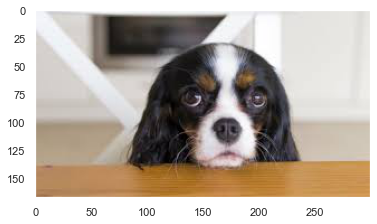

In [247]:
#for dogs
# Path to your 'birds' folder
dogs_folder = Path("/Users/lanahaj/Desktop/HW1_data_updated/dogs")

# Load and display images
for img_path in dogs_folder.glob('*.jpg'):
    img_dog = Image.open(img_path)
    plt.grid(False)
    plt.imshow(img_dog)
    plt.show()
    break

In [241]:
input_tensor = preprocess(img_dog)
input_batch_dog = input_tensor.unsqueeze(0)  # Create a mini-batch as expected by the model

with torch.no_grad():  # No need to compute gradients
    output = model(input_batch_dog)
# Convert the output logits to probabilities
probabilities = torch.nn.functional.softmax(output[0], dim=0)

# Get the top 1 predicted class
top_prob, top_catid = torch.topk(probabilities, 1)

# Print the top class and its probability
print(f"Top predicted class ID: {top_catid.item()} with probability: {top_prob.item()}")




Top predicted class ID: 152 with probability: 0.5551227331161499


As written in the imagenet_class_index json file that shows what is the label of each index, the label of this image is **Japanese_spaniel**

# Step 6:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


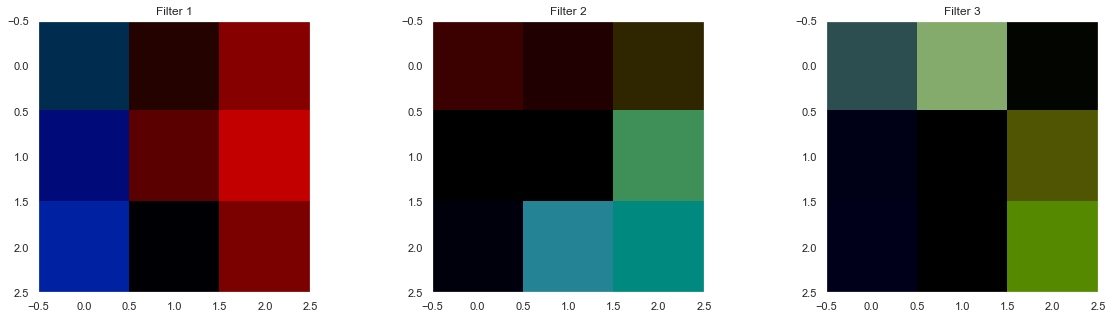

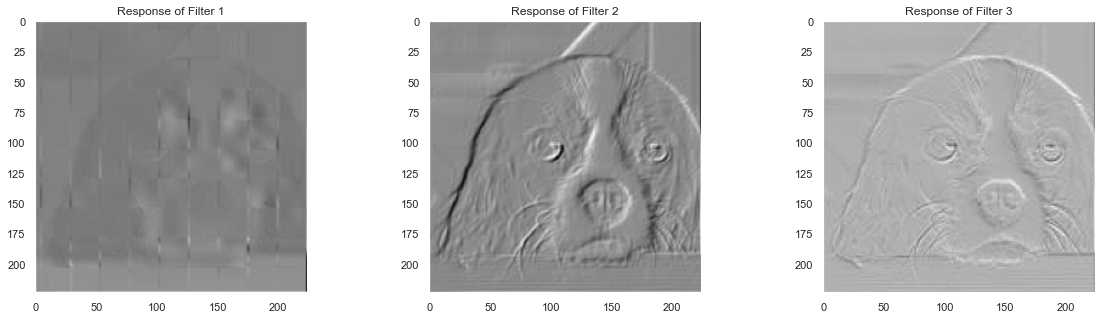

In [256]:

# Access the first convolutional layer
first_conv_layer = model.features[0]

# Access its weight (filters)
filters = first_conv_layer.weight.data.clone()

# Plot filters
fig, axs = plt.subplots(1, 3, figsize=(20, 5))
for i, filter in enumerate(filters[:3]):
    filter_img = filter.permute(1, 2, 0)

    axs[i].grid(False)
    axs[i].imshow(filter_img, cmap='gray')
    axs[i].set_title(f'Filter {i+1}')

plt.show()

# Forward the image through the first conv layer
with torch.no_grad():
    first_layer_output = first_conv_layer(input_batch_dog)

# Plot the response of the first 3 filters
fig, axs = plt.subplots(1, 3, figsize=(20, 5))
for i in range(3):
    response = first_layer_output[0, i].numpy()
    axs[i].grid(False)
    axs[i].imshow(response, cmap='gray')
    axs[i].set_title(f'Response of Filter {i+1}')
plt.show()


The first filter in the first layer of VGG16 seems to emphasize the overall shape of the dog, providing a clear focus on its silhouette. The second filter appears to strike a balance between capturing details and emphasizing the dog's shape. Meanwhile, the third filter seems to primarily focus on the finer details within the image. When observing the responses of these filters to the image, it becomes apparent that they all successfully locate the presence of the dog. However, each filter prioritizes different aspects of the image, with varying degrees of emphasis on shape and detail.